In [1]:
import numpy as np
import pandas as pd

from plotnine import *
from sklearn.metrics import precision_recall_curve

$$prec = \frac{tp}{tp + fp} \qquad rec = \frac{tp}{tp + fn}$$

olgu mudel $N$, mis hinab andmepunte juhuslikult ühtlasest jaotusest $S \sim U(0, 1)$
$$\hat{y} = 
\begin{cases}
        0, & \text{if } S \leq 0.5 \\
        1, & \text{if } S \gt 0.5
\end{cases}$$

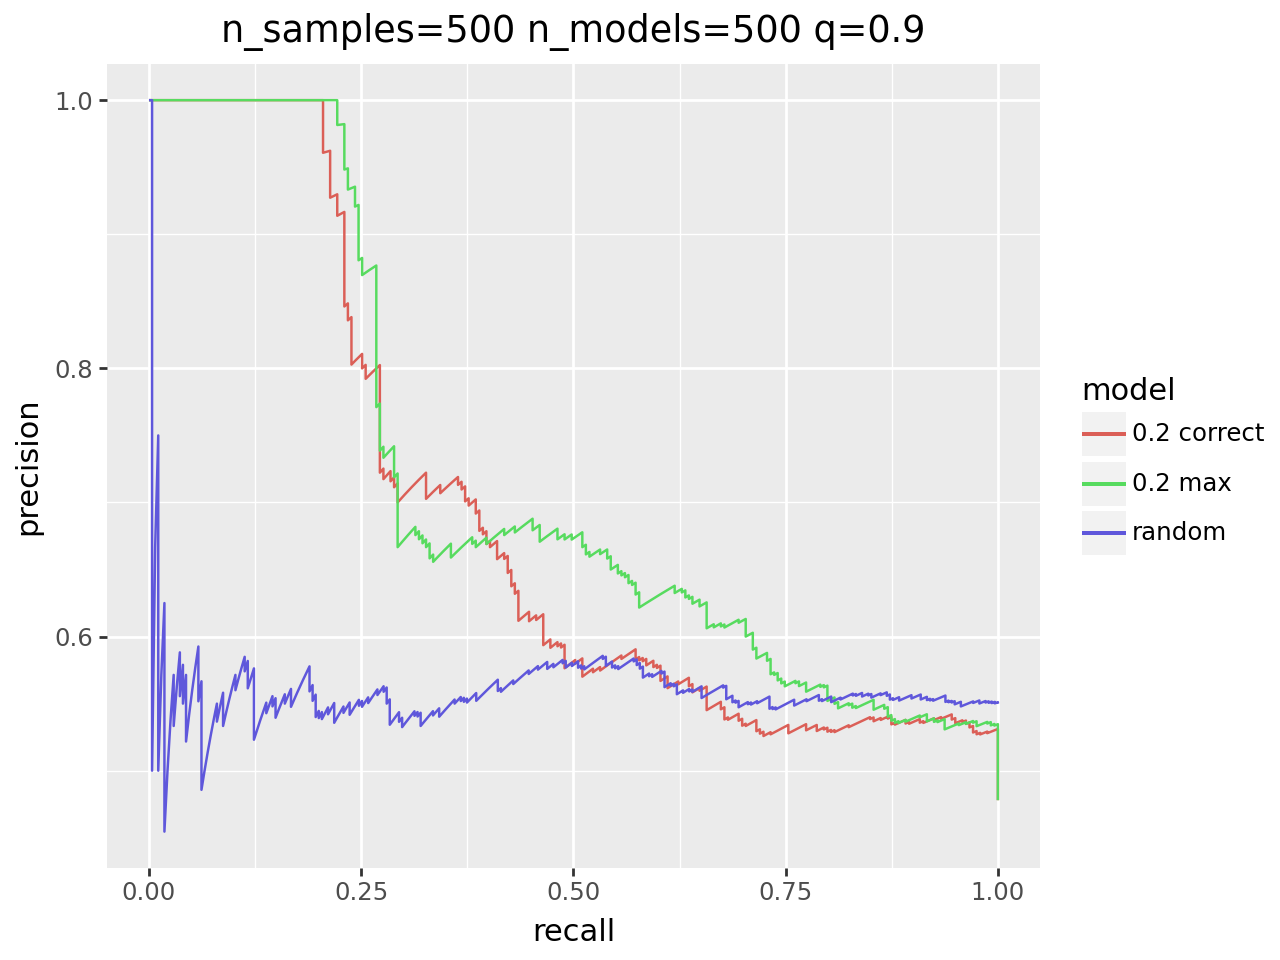

In [59]:
n_samples = 500
n_models = 500
quantile = 0.9
tenth = int(n_samples / 10)
shuffle = np.random.permutation(n_samples)

df = pd.DataFrame(columns=['precision', 'recall', 'model'])
y_rand = np.random.binomial(n=1, p=0.5, size=n_samples)
y_rigged = np.concatenate((np.zeros(tenth), np.ones(tenth), np.random.binomial(n=1, p=0.5, size=tenth * 8)))[shuffle]
# E y_rigged = (1/10 * 1) + (1/10 * 0) + (8/10 E y|y~Bin(1, 0.5)) = 0.1 + 0.0 + 0.4 = 0.5 = E y_rand

# random
null_scores = [np.random.uniform(size=n_samples) for _ in range(n_models)]
null_score_q = np.quantile(null_scores, quantile, axis=0)
null_p, null_r, _ = precision_recall_curve(y_rand, y_score=null_score_q)
df_null = pd.DataFrame({'precision': null_p, 'recall': null_r, 'model': np.repeat('random', null_p.shape[0])})

# 0.2 max
null_20_max = lambda: np.concatenate((np.zeros(tenth), np.ones(tenth), np.random.uniform(size=tenth * 8)))[shuffle]
null_20_max_scores = [null_20_max() for _ in range(n_models)]
null_20_max_q = np.quantile(null_20_max_scores, quantile, axis=0)
null_20_max_p, null_20_max_r, _ = precision_recall_curve(y_rigged, y_score=null_20_max_q)
df_null_20_max = pd.DataFrame({'precision': null_20_max_p, 'recall': null_20_max_r, 'model': np.repeat('0.2 max', null_20_max_p.shape[0])})

# 0.2 correct
null_20 = lambda: np.concatenate((np.random.uniform(low=0.0, high=0.5, size=tenth),
                                  np.random.uniform(low=0.5 + 1e-6, high=1.0, size=tenth),
                                  np.random.uniform(size=tenth * 8)))[shuffle]
null_20_scores = [null_20() for _ in range(n_models)]
null_20_q = np.quantile(null_20_scores, quantile, axis=0)
null_20_p, null_20_r, _ = precision_recall_curve(y_rigged, y_score=null_20_q)
df_null_20 = pd.DataFrame({'precision': null_20_p, 'recall': null_20_r, 'model': np.repeat('0.2 correct', null_20_p.shape[0])})

g = ggplot(data=pd.concat((df_null, df_null_20_max, df_null_20)))
g = g + xlab('recall') + ylab('precision') + labs(title=f"n_samples={n_samples} n_models={n_models} q={quantile}")
g = g + aes('recall', 'precision', color='model')
g = g + geom_path()
g